In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('resources/data.csv')
df_copy = df.loc[:, (df != 0).any(axis=0)]
df_copy = df_copy.drop(labels=['Sprint', 'Severity of the threat'], axis=1)

In [2]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 12 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Change code line number                   516 non-null    int64 
 1   Number of vulnerable modules              516 non-null    int64 
 2   Number of people involved in development  516 non-null    int64 
 3   Time to complete each version             516 non-null    object
 4   Commit frequency                          516 non-null    object
 5   Type of environment                       516 non-null    object
 6   Number of libraries detected errors       516 non-null    int64 
 7   Scan date                                 516 non-null    object
 8   Number of potential weaknesses            516 non-null    int64 
 9   Số lượng lỗ hổng cấu hình môi trường      516 non-null    int64 
 10  Evaluate                                  516 non-

In [3]:
df_copy

,Change code line number,Number of vulnerable modules,Number of people involved in development,Time to complete each version,Commit frequency,Type of environment,Number of libraries detected errors,Scan date,Number of potential weaknesses,Số lượng lỗ hổng cấu hình môi trường,Evaluate,Repo
0,19,1,2,5 days,Daily,Cloud,22,2025-02-17 00:00:00,26,4,4,admin-jlpt
1,1152,1,2,5 days,Daily,Cloud,22,2025-02-18 00:00:00,26,4,4,admin-jlpt
2,100,1,2,5 days,Daily,Cloud,22,2025-02-19 00:00:00,26,4,4,admin-jlpt
3,221,1,2,5 days,Daily,Cloud,22,2025-02-20 00:00:00,26,4,4,admin-jlpt
4,96,1,2,5 days,Daily,Cloud,22,2025-02-22 00:00:00,26,4,4,admin-jlpt
...,...,...,...,...,...,...,...,...,...,...,...,...
511,530,1,8,5 days,Weekly,Cloud,40,2025-01-09 00:00:00,42,2,2,payment-system
512,1996,1,6,5 days,Daily,Cloud,39,2025-02-04 00:00:00,40,1,3,user-management
513,1986,1,8,7 days,Weekly,Cloud,14,2025-01-15 00:00:00,16,2,3,payment-system
514,435,1,7,10 days,Monthly,Cloud,29,2025-03-14 00:00:00,32,3,1,admin-jlpt


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess_timeseries_dataframe(df: pd.DataFrame):
    df = df.copy()
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.drop(labels=['Sprint', 'Severity of the threat'], axis=1)
    df['Scan date'] = pd.to_datetime(df['Scan date'])

    categorical_columns = ['Time to complete each version', 'Commit frequency', 'Type of environment', 'Repo']
    group_sum_col = 'Change code line number'
    target_col = 'Evaluate'
    date_col = 'Scan date'

    all_dfs = []
    for repo, group in df.groupby('Repo'):
        # group by date to avoid duplicates before reindexing
        group = group.groupby(date_col).agg({
            group_sum_col: 'sum',
            'Number of vulnerable modules': 'mean',
            'Number of people involved in development': 'mean',
            'Number of libraries detected errors': 'mean',
            'Number of potential weaknesses': 'mean',
            'Số lượng lỗ hổng cấu hình môi trường': 'mean',
            target_col: 'first',
            **{col: 'first' for col in categorical_columns}
        }).sort_index()

        # create full date index and reindex
        all_dates = pd.date_range(start=group.index.min(), end=group.index.max(), freq='D')
        group = group.reindex(all_dates, method='ffill')
        group[date_col] = group.index
        group['Repo'] = repo

        # identify filled-in rows and set code line to 0
        original_dates = df[df['Repo'] == repo]['Scan date'].unique()
        group[group_sum_col] = group[group_sum_col].where(group.index.isin(original_dates), 0)

        all_dfs.append(group)

    df_filled = pd.concat(all_dfs).reset_index(drop=True)

    # encode categoricals
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_filled[col] = le.fit_transform(df_filled[col])
        label_encoders[col] = le

    # normalize features (excluding Scan date, Repo, Evaluate)
    feature_cols = df_filled.columns.difference([date_col, 'Repo', target_col])
    scaler = StandardScaler()
    df_filled[feature_cols] = scaler.fit_transform(df_filled[feature_cols])

    # final outputs
    X = df_filled.drop(columns=[date_col, 'Repo', target_col])
    y = df_filled[target_col]
    meta = df_filled[[date_col, 'Repo']]

    return X, y, meta, label_encoders, scaler

In [5]:
X, y, meta, encoders, scaler = preprocess_timeseries_dataframe(df)
X

,Change code line number,Number of vulnerable modules,Number of people involved in development,Number of libraries detected errors,Number of potential weaknesses,Số lượng lỗ hổng cấu hình môi trường,Time to complete each version,Commit frequency,Type of environment
0,1.078302,0.0,-0.649854,0.488260,0.552000,0.950836,-1.198149,0.096718,0.0
1,0.010589,0.0,-0.067334,-1.500259,-1.611377,-1.724206,-1.198149,-1.099074,0.0
2,-0.064960,0.0,-0.566637,-0.601339,-0.556731,0.568687,1.233915,-1.099074,0.0
3,0.430454,0.0,1.929876,0.706180,0.579042,-1.724206,0.017883,1.292511,0.0
4,0.766747,0.0,-0.316985,0.542740,0.538479,-0.004536,1.233915,0.096718,0.0
...,...,...,...,...,...,...,...,...,...
267,1.052897,0.0,0.431968,-0.002059,0.038198,0.568687,-1.198149,-1.099074,0.0
268,1.032839,0.0,-1.731676,-0.383419,-0.475604,-1.342057,1.233915,1.292511,0.0
269,0.007915,0.0,-1.565242,1.278220,1.146929,-1.724206,-1.198149,1.292511,0.0
270,-0.400584,0.0,0.931271,1.931980,1.958195,0.568687,-1.198149,1.292511,0.0


In [6]:
y

0      4
1      3
2      2
3      3
4      2
      ..
267    4
268    4
269    1
270    1
271    3
Name: Evaluate, Length: 272, dtype: int64

In [7]:
meta

,Scan date,Repo
0,2025-01-01,0
1,2025-01-02,0
2,2025-01-03,0
3,2025-01-04,0
4,2025-01-05,0
...,...,...
267,2025-03-27,2
268,2025-03-28,2
269,2025-03-29,2
270,2025-03-30,2


In [8]:
ori_X = scaler.inverse_transform(X[list(scaler.feature_names_in_)]).astype(int)
ori_X = pd.DataFrame(data=ori_X, columns=list(scaler.feature_names_in_))

In [9]:
for col in ('Time to complete each version', 'Commit frequency', 'Type of environment'):
    ori_X[col] = encoders[col].inverse_transform(ori_X[col])

In [10]:
ori_X

,Change code line number,Commit frequency,Number of libraries detected errors,Number of people involved in development,Number of potential weaknesses,Number of vulnerable modules,Số lượng lỗ hổng cấu hình môi trường,Time to complete each version,Type of environment
0,3494,Monthly,31,3,34,1,3,10 days,Cloud
1,1897,Daily,7,5,8,1,1,10 days,Cloud
2,1784,Daily,18,4,21,1,3,7 days,Cloud
3,2525,Weekly,34,9,35,1,1,5 days,Cloud
4,3028,Monthly,32,4,34,1,2,7 days,Cloud
...,...,...,...,...,...,...,...,...,...
267,3456,Daily,25,6,28,1,3,10 days,Cloud
268,3426,Weekly,20,1,22,1,1,7 days,Cloud
269,1893,Weekly,41,2,42,1,1,10 days,Cloud
270,1282,Weekly,49,7,52,1,3,10 days,Cloud


In [11]:
ori_meta  = meta.copy()
ori_meta['Repo'] = encoders['Repo'].inverse_transform(ori_meta['Repo'])
ori_meta

,Scan date,Repo
0,2025-01-01,admin-jlpt
1,2025-01-02,admin-jlpt
2,2025-01-03,admin-jlpt
3,2025-01-04,admin-jlpt
4,2025-01-05,admin-jlpt
...,...,...
267,2025-03-27,user-management
268,2025-03-28,user-management
269,2025-03-29,user-management
270,2025-03-30,user-management


In [12]:
ori_y = pd.DataFrame(data=y, columns=['Evaluate'])
ori_y

,Evaluate
0,4
1,3
2,2
3,3
4,2
...,...
267,4
268,4
269,1
270,1


In [13]:
col_names = list(ori_X.columns) + list(ori_meta.columns) + list(ori_y.columns)
ori_data = pd.concat([ori_X, ori_meta, ori_y], ignore_index=True, axis=1)
ori_data.columns = col_names
ori_data = ori_data[df_copy.columns.tolist()]
ori_data.to_csv('resources/data_cleaned.csv', index=False)

### Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class BayesianDense(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.w_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.b_mu = nn.Parameter(torch.Tensor(out_features))
        self.b_sigma = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.w_mu, mode='fan_in')
        nn.init.constant_(self.w_sigma, -3)
        nn.init.constant_(self.b_mu, 0.1)
        nn.init.constant_(self.b_sigma, -3)

    def forward(self, x):
        w = Normal(self.w_mu, torch.exp(self.w_sigma)).rsample()
        b = Normal(self.b_mu, torch.exp(self.b_sigma)).rsample()
        return F.linear(x, w, b)

class MyModel(nn.Module):
    def __init__(self, input_features=9, timesteps=5, num_classes=5):
        super().__init__()
        assert input_features == 9, 'only 9 features supported right now'

        self.input_dense = BayesianDense(input_features, 32)
        self.lstm = nn.LSTM(32, 64, num_layers=2, batch_first=True)

        self.bayesian_layers = nn.ModuleList([
            BayesianDense(64, 64),
            BayesianDense(64, 48),
            BayesianDense(48, 48),
            BayesianDense(48, 32)
        ])

        self.dropout = nn.Dropout(0.1)
        self.final_dense = BayesianDense(32, num_classes)

        self.swish = lambda x: x * torch.sigmoid(x)

    def forward(self, x):
        batch_size, T, _ = x.shape

        x = self.swish(self.input_dense(x))  # (batch, T, 32)
        lstm_out, _ = self.lstm(x)  # (batch, T, 64)

        x = lstm_out
        for layer in self.bayesian_layers:
            x = self.swish(layer(x))

        x = self.dropout(x)
        logits = self.final_dense(x)  # (batch, T, num_classes)
        return logits
    
def evaluate(model, loader, verbose=True):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            output = model(x_batch)  # (batch, T, num_classes)
            preds = output.argmax(dim=-1)
            all_preds.append(preds.flatten())
            all_labels.append(y_batch.flatten())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = (all_preds == all_labels).float().mean().item()
    if verbose:
        print(f"accuracy: {acc:.4f}")
    return acc

def train(model, loader, optimizer, criterion, val_loader=None, epochs=100):
    model.train()
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in loader:
            optimizer.zero_grad()
            output = model(x_batch)  # shape: (batch, T, num_classes)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        train_losses.append(avg_loss)

        # Validation accuracy
        if val_loader:
            acc = evaluate(model, val_loader, verbose=False)
            val_accuracies.append(acc)

        print(f"epoch {epoch+1}: loss = {avg_loss:.4f}" + (f", val. acc. = {acc:.4f}" if val_loader else ""))

    return train_losses, val_accuracies

In [15]:
from torch.utils.data import Dataset, DataLoader, random_split

class RepoDataset(Dataset):
    def __init__(self, X_df, y_series, meta_df, timesteps=5):
        self.samples = []
        self.meta = []

        grouped = meta_df.groupby("Repo")
        for repo_id, group_indices in grouped.groups.items():
            group = meta_df.loc[group_indices].sort_values("Scan date")
            sorted_idx = group.index.tolist()
            if len(sorted_idx) < timesteps:
                continue
            for i in range(len(sorted_idx) - timesteps + 1):
                window_idx = sorted_idx[i:i + timesteps]
                x_seq = torch.tensor(X_df.loc[window_idx].values, dtype=torch.float32)
                y_seq = torch.tensor(y_series.loc[window_idx].values, dtype=torch.long)
                # meta_seq = meta_df.loc[window_idx].iloc[-1]
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
train_repos = [0, 1]
test_repos = [2]

train_mask = meta['Repo'].isin(train_repos)
test_mask = meta['Repo'].isin(test_repos)

X_train = X[train_mask]
y_train = y[train_mask]
meta_train = meta[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]
meta_test = meta[test_mask]

timesteps = 5
train_dataset = RepoDataset(X_train, y_train, meta_train, timesteps=timesteps)
test_dataset = RepoDataset(X_test, y_test, meta_test, timesteps=timesteps)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


epoch 1: loss = 1.5398, val. acc. = 0.2605
epoch 2: loss = 1.4744, val. acc. = 0.2605
epoch 3: loss = 1.4230, val. acc. = 0.2605
epoch 4: loss = 1.3806, val. acc. = 0.2605
epoch 5: loss = 1.3559, val. acc. = 0.2605
epoch 6: loss = 1.3384, val. acc. = 0.2512
epoch 7: loss = 1.3353, val. acc. = 0.2837
epoch 8: loss = 1.3301, val. acc. = 0.2488
epoch 9: loss = 1.2846, val. acc. = 0.2558
epoch 10: loss = 1.2709, val. acc. = 0.2698
epoch 11: loss = 1.2511, val. acc. = 0.2721
epoch 12: loss = 1.2155, val. acc. = 0.2884
epoch 13: loss = 1.1831, val. acc. = 0.2698
epoch 14: loss = 1.1795, val. acc. = 0.2744
epoch 15: loss = 1.1071, val. acc. = 0.2349
epoch 16: loss = 1.0925, val. acc. = 0.2372
epoch 17: loss = 1.0788, val. acc. = 0.2047
epoch 18: loss = 1.0669, val. acc. = 0.2140
epoch 19: loss = 0.9937, val. acc. = 0.1977
epoch 20: loss = 0.9934, val. acc. = 0.2395
epoch 21: loss = 0.9171, val. acc. = 0.2000
epoch 22: loss = 0.8894, val. acc. = 0.1930
epoch 23: loss = 0.8542, val. acc. = 0.20

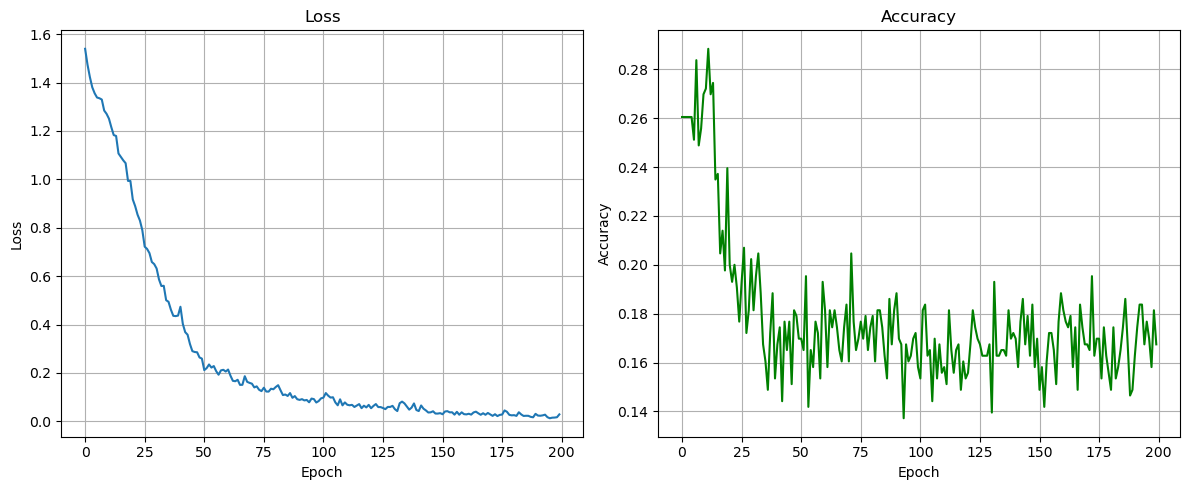

In [16]:
model = MyModel(input_features=9, timesteps=timesteps, num_classes=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_accuracies = train(
    model, train_loader, optimizer, criterion,
    val_loader=test_loader, epochs=200
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
class RandomDataset(Dataset):
    def __init__(self, X_df, y_series, meta_df, timesteps=5):
        self.samples = []

        grouped = meta_df.groupby("Repo")
        for repo_id, group_indices in grouped.groups.items():
            group = meta_df.loc[group_indices].sort_values("Scan date")
            sorted_idx = group.index.tolist()
            if len(sorted_idx) < timesteps:
                continue
            for i in range(len(sorted_idx) - timesteps + 1):
                window_idx = sorted_idx[i:i + timesteps]
                x_seq = torch.tensor(X_df.loc[window_idx].values, dtype=torch.float32)
                y_seq = torch.tensor(y_series.loc[window_idx].values, dtype=torch.long)
                # meta_seq = meta_df.loc[window_idx].iloc[-1].to_dict()
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
full_dataset = RandomDataset(X, y, meta, timesteps=5)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epoch 1: loss = 1.5899, val. acc. = 0.3846
epoch 2: loss = 1.5018, val. acc. = 0.3885
epoch 3: loss = 1.4339, val. acc. = 0.3885
epoch 4: loss = 1.4051, val. acc. = 0.3231
epoch 5: loss = 1.4091, val. acc. = 0.3846
epoch 6: loss = 1.3834, val. acc. = 0.3808
epoch 7: loss = 1.3710, val. acc. = 0.3077
epoch 8: loss = 1.3481, val. acc. = 0.3769
epoch 9: loss = 1.3634, val. acc. = 0.3692
epoch 10: loss = 1.3385, val. acc. = 0.3731
epoch 11: loss = 1.3446, val. acc. = 0.3846
epoch 12: loss = 1.3205, val. acc. = 0.3846
epoch 13: loss = 1.3212, val. acc. = 0.4269
epoch 14: loss = 1.2819, val. acc. = 0.3962
epoch 15: loss = 1.2788, val. acc. = 0.3808
epoch 16: loss = 1.2580, val. acc. = 0.3769
epoch 17: loss = 1.2618, val. acc. = 0.3923
epoch 18: loss = 1.2660, val. acc. = 0.3923
epoch 19: loss = 1.2388, val. acc. = 0.4500
epoch 20: loss = 1.1773, val. acc. = 0.3962
epoch 21: loss = 1.1625, val. acc. = 0.4538
epoch 22: loss = 1.1162, val. acc. = 0.4154
epoch 23: loss = 1.1064, val. acc. = 0.46

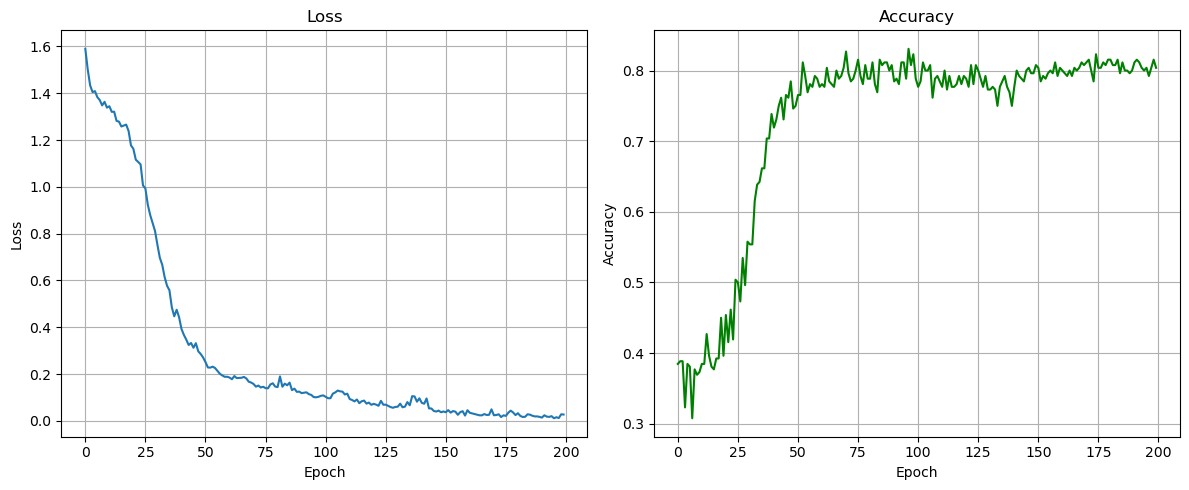

In [18]:
model = MyModel(input_features=9, timesteps=timesteps, num_classes=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_accuracies = train(
    model, train_loader, optimizer, criterion,
    val_loader=test_loader, epochs=200
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
class RepoSplitTimeSeriesDataset(Dataset):
    def __init__(self, X_df, y_series, meta_df, timesteps=5, mode="train", split_ratio=0.8):
        self.samples = []
        assert mode in ["train", "val"], "mode must be 'train' or 'val'"

        grouped = meta_df.groupby("Repo")

        for repo_id, group_indices in grouped.groups.items():
            # sort by time within each repo
            group = meta_df.loc[group_indices].sort_values("Scan date")
            sorted_idx = group.index.tolist()

            total = len(sorted_idx)
            split_point = int(total * split_ratio)

            if total < timesteps:
                continue  # skip short repos

            if mode == "train":
                use_idx = sorted_idx[:split_point]
            else:  # val
                use_idx = sorted_idx[split_point:]

            # re-slide within the selected portion
            for i in range(len(use_idx) - timesteps + 1):
                window_idx = use_idx[i:i + timesteps]
                x_seq = torch.tensor(X_df.loc[window_idx].values, dtype=torch.float32)
                y_seq = torch.tensor(y_series.loc[window_idx].values, dtype=torch.long)
                meta_seq = meta_df.loc[window_idx].iloc[-1].to_dict()
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    

timesteps = 5
train_dataset = RepoSplitTimeSeriesDataset(X, y, meta, timesteps=timesteps, mode="train", split_ratio=0.8)
val_dataset = RepoSplitTimeSeriesDataset(X, y, meta, timesteps=timesteps, mode="val", split_ratio=0.8)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

epoch 1: loss = 1.6289, val. acc. = 0.1462
epoch 2: loss = 1.5645, val. acc. = 0.3346
epoch 3: loss = 1.4863, val. acc. = 0.3923
epoch 4: loss = 1.4438, val. acc. = 0.3846
epoch 5: loss = 1.4065, val. acc. = 0.3731
epoch 6: loss = 1.3811, val. acc. = 0.3385
epoch 7: loss = 1.3713, val. acc. = 0.3846
epoch 8: loss = 1.3293, val. acc. = 0.3885
epoch 9: loss = 1.3340, val. acc. = 0.4000
epoch 10: loss = 1.3248, val. acc. = 0.3615
epoch 11: loss = 1.3172, val. acc. = 0.4115
epoch 12: loss = 1.3204, val. acc. = 0.4077
epoch 13: loss = 1.2927, val. acc. = 0.4077
epoch 14: loss = 1.2724, val. acc. = 0.3885
epoch 15: loss = 1.2760, val. acc. = 0.4308
epoch 16: loss = 1.2576, val. acc. = 0.4077
epoch 17: loss = 1.2330, val. acc. = 0.4538
epoch 18: loss = 1.2475, val. acc. = 0.4769
epoch 19: loss = 1.2193, val. acc. = 0.4577
epoch 20: loss = 1.1780, val. acc. = 0.4923
epoch 21: loss = 1.1725, val. acc. = 0.5000
epoch 22: loss = 1.0810, val. acc. = 0.4846
epoch 23: loss = 1.0590, val. acc. = 0.51

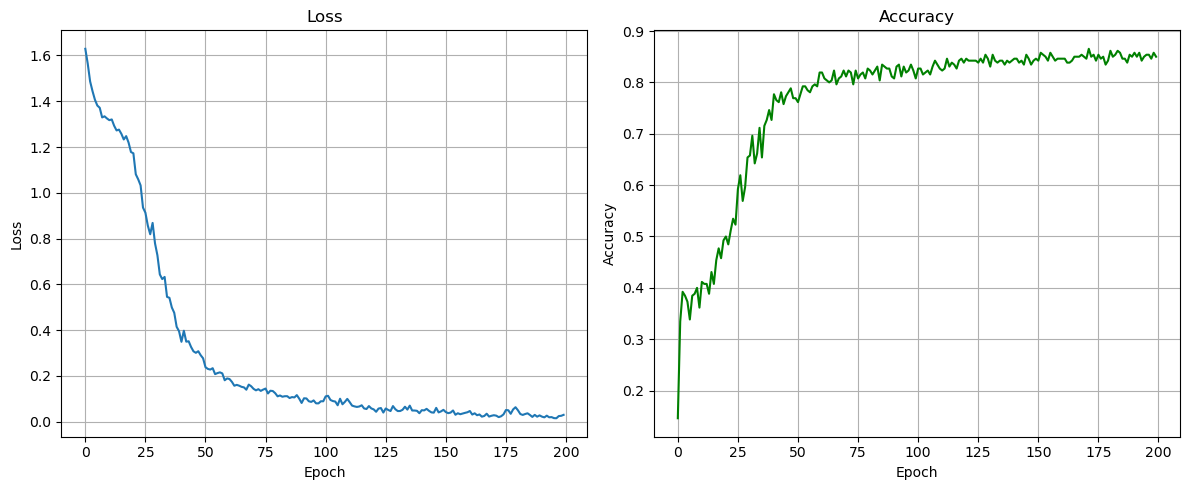

In [20]:
model = MyModel(input_features=9, timesteps=timesteps, num_classes=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_accuracies = train(
    model, train_loader, optimizer, criterion,
    val_loader=test_loader, epochs=200
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
print(y.value_counts(normalize=True))

Evaluate
4    0.352941
1    0.253676
3    0.205882
2    0.187500
Name: proportion, dtype: float64
